In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

In [5]:
def clean_and_analyze_data(df, dataset_name):
    print(f"\n========== {dataset_name} DATASET ==========")

    print("Initial Shape:", df.shape)

    print("\nNull values before cleaning:")
    print(df.isnull().sum())

    df = df.dropna()
    print("\nShape after removing null values:", df.shape)

    dup_rows = df.duplicated().sum()
    print("\nDuplicate rows found:", dup_rows)

    df = df.drop_duplicates()
    print("Shape after removing duplicate rows:", df.shape)

    dup_cols = df.columns[df.columns.duplicated()]
    print("\nDuplicate columns:", list(dup_cols))

    df = df.loc[:, ~df.columns.duplicated()]

    print("\nFinal Dataset Info:")
    print(df.info())

    return df

In [6]:
day_df = pd.read_csv("day.csv")
day_df = clean_and_analyze_data(day_df, "DAY")


========== DAY DATASET ==========
Initial Shape: (731, 16)

Null values before cleaning:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Shape after removing null values: (731, 16)

Duplicate rows found: 0
Shape after removing duplicate rows: (731, 16)

Duplicate columns: []

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   w

In [7]:
X = day_df.drop(columns=['instant', 'casual', 'registered', 'yr', 'dteday'])
y = day_df['cnt']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [10]:
param_grid = {
    'n_estimators': [5, 7, 15],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

In [11]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4], 'n_estimators': [5, 7, 15],
                         'subsample': [0.7, 1]},
             scoring='r2', verbose=1)

In [13]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 15, 'subsample': 1}
Best CV R² Score: 0.9483773657557151


In [14]:
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\nDAY DATASET - XGBOOST PERFORMANCE AFTER TUNING")
print(f"Training R² Score : {train_r2:.4f}")
print(f"Training RMSE     : {train_rmse:.2f}")
print(f"Test R² Score     : {test_r2:.4f}")
print(f"Test RMSE         : {test_rmse:.2f}")
print(f"Test MAE          : {test_mae:.2f}")


DAY DATASET - XGBOOST PERFORMANCE AFTER TUNING
Training R² Score : 0.9516
Training RMSE     : 421.30
Test R² Score     : 0.9513
Test RMSE         : 441.89
Test MAE          : 364.90


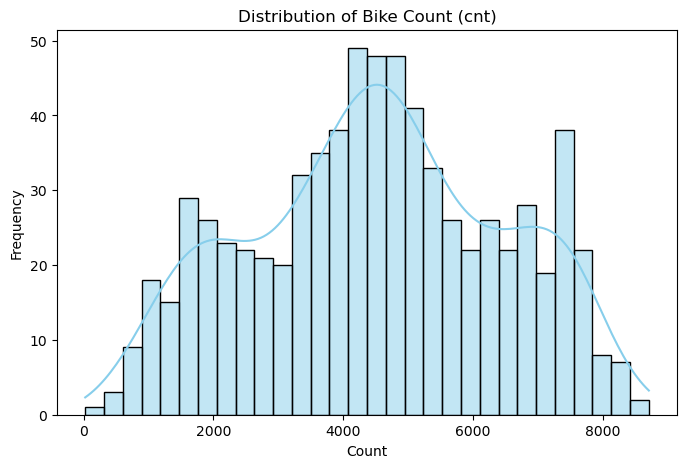

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
sns.histplot(day_df['cnt'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Bike Count (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

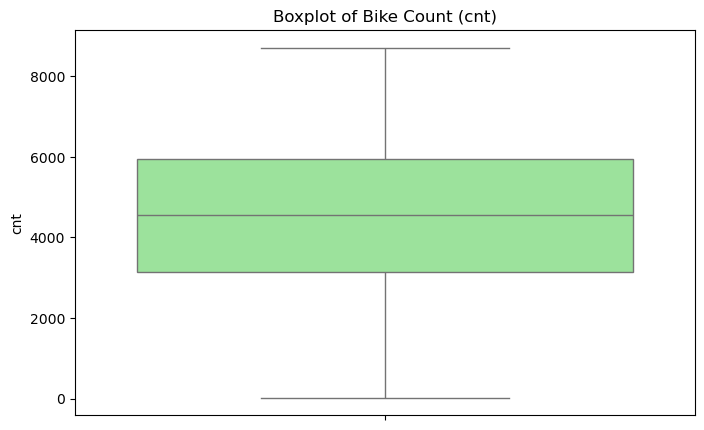

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=day_df['cnt'], color='lightgreen')
plt.title("Boxplot of Bike Count (cnt)")
plt.show()


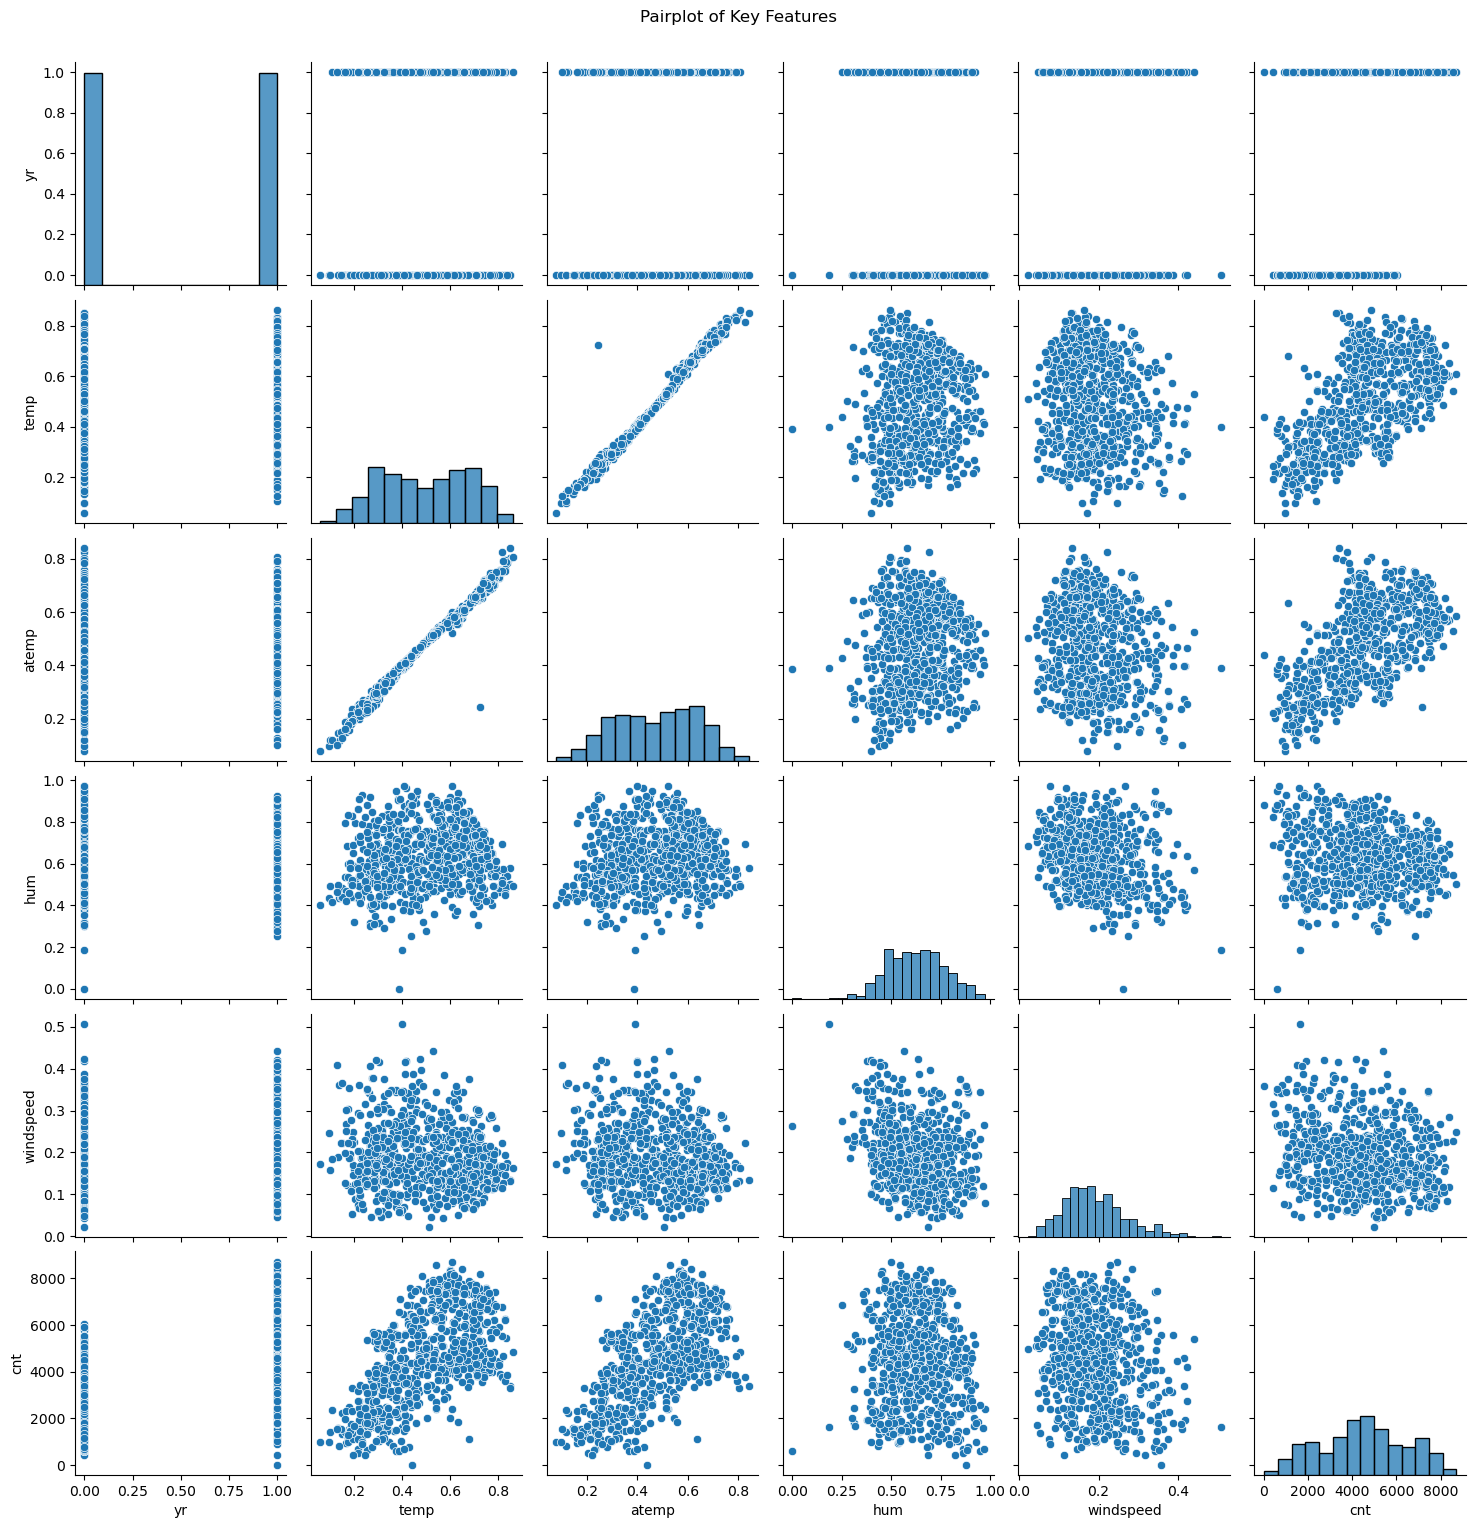

In [17]:
features = ['yr', 'temp', 'atemp', 'hum', 'windspeed','cnt']
sns.pairplot(day_df[features])
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

In [18]:
day_feature_cols = [
    "season", "mnth", "holiday", "weekday",
    "workingday", "weathersit",
    "temp", "atemp", "hum", "windspeed"
]


In [19]:
def recursive_forecast_day(model, input_df, steps=6):
    """
    Recursive forecasting for DAY dataset (daily basis)
    """
    predictions = []
    current_input = input_df.copy()

    for step in range(steps):
        pred = model.predict(current_input)[0]
        predictions.append(pred)

        # Update month safely (1–12)
        if "mnth" in current_input.columns:
            current_input["mnth"] = (current_input["mnth"] % 12) + 1

        # Rotate weekday (0–6)
        if "weekday" in current_input.columns:
            current_input["weekday"] = (current_input["weekday"] + 1) % 7

    return predictions

In [20]:
DAY_NAMES = ["Sunday", "Monday", "Tuesday", "Wednesday",
             "Thursday", "Friday", "Saturday"]


In [21]:
def predict_next_6_days(model, user_input, feature_cols):
    """
    Predict next 6 days (daily forecasting) and print results
    """

    input_df = pd.DataFrame([user_input])[feature_cols]

    preds = recursive_forecast_day(
        model=model,
        input_df=input_df,
        steps=6
    )

    start_weekday = user_input["weekday"]

    day_labels = [
        DAY_NAMES[(start_weekday + i) % 7]
        for i in range(6)
    ]

    result_df = pd.DataFrame({
        "Day": day_labels,
        "Predicted Bike Rentals (cnt)": np.round(preds, 2)
    })

    # Remove index for clean printing
    result_df.index = [""] * len(result_df)

    return result_df

In [22]:
day_input = {
    "season": 1,
    "mnth": 1,
    "holiday": 0,
    "weekday": 0,      # Tuesday
    "workingday": 1,
    "weathersit": 2,
    "temp": 0.344167,
    "atemp": 0.363625,
    "hum": 0.805833,
    "windspeed": 0.160446
}


In [23]:
X = day_df.drop(columns=[
    'instant', 'casual', 'registered', 'yr', 'dteday', 'cnt'
])
y = day_df['cnt']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [25]:
print("Model trained on features:")
print(best_model.get_booster().feature_names)

Model trained on features:
['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [26]:
daily_forecast = predict_next_6_days(
    model=best_model,
    user_input=day_input,
    feature_cols=day_feature_cols
)

print(daily_forecast)

        Day  Predicted Bike Rentals (cnt)
     Sunday                   3193.620117
     Monday                   3181.189941
    Tuesday                   3181.189941
  Wednesday                   3181.189941
   Thursday                   3181.189941
     Friday                   3181.189941


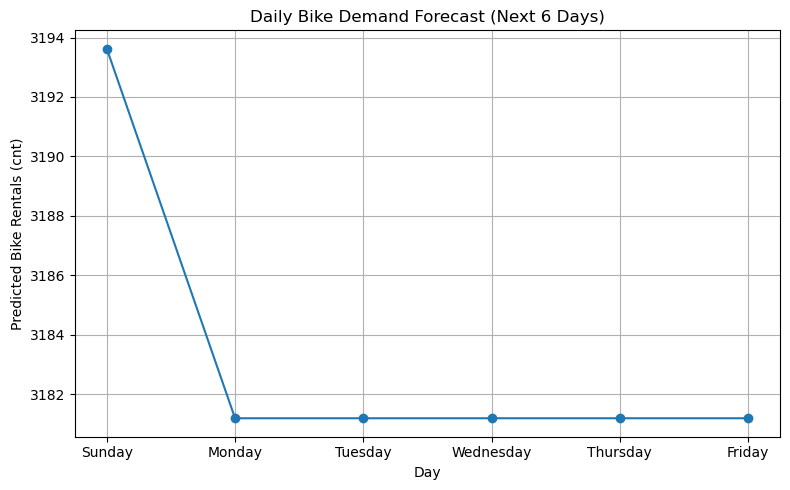

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(
    daily_forecast["Day"],
    daily_forecast["Predicted Bike Rentals (cnt)"],
    marker='o'
)

plt.title("Daily Bike Demand Forecast (Next 6 Days)")
plt.xlabel("Day")
plt.ylabel("Predicted Bike Rentals (cnt)")
plt.grid(True)
plt.tight_layout()
plt.show()

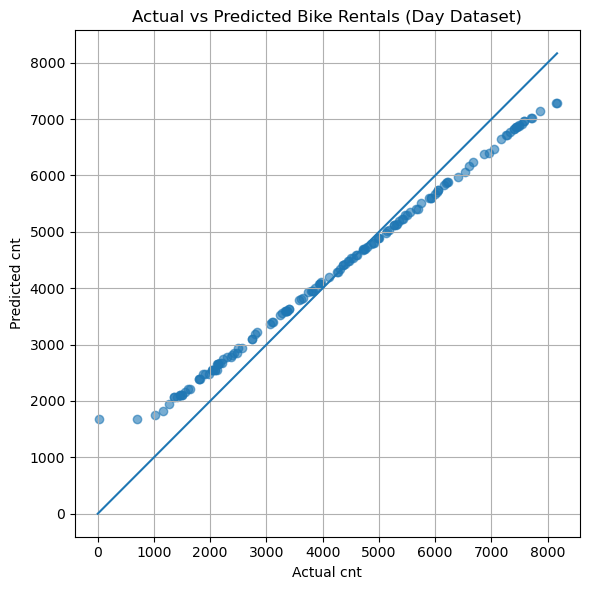

In [28]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_test_pred, alpha=0.6)

# Ideal prediction line
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([0, max_val], [0, max_val])

plt.title("Actual vs Predicted Bike Rentals (Day Dataset)")
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
pip install numpy pandas scikit-learn xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [14]:
# =====================================================
# Final Corrected Performance Comparison - Day Dataset
# =====================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# -----------------------------
# Load Dataset
# -----------------------------
data = pd.read_csv("day.csv")

# -----------------------------
# Feature Engineering (CRITICAL)
# -----------------------------

# Keep 'yr' and create time index
data["time_index"] = np.arange(len(data))

# Drop leakage / non-numeric columns
data.drop(columns=["dteday", "instant", "casual", "registered"], inplace=True)

# Log transform target (stabilizes variance)
y = np.log1p(data["cnt"])
X = data.drop("cnt", axis=1)

# -----------------------------
# Time-based Split (80% / 20%)
# -----------------------------
split_index = int(len(data) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# -----------------------------
# Models (Properly Scaled)
# -----------------------------
models = {
    "Linear Regression": LinearRegression(),

    "Ridge Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),

    "Lasso Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Lasso(alpha=0.001, max_iter=20000))
    ]),

    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000))
    ]),

    "KNN Regressor": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=7))
    ]),

    "SVR (RBF Kernel)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf", C=100, gamma="scale"))
    ]),

    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),

    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ),

    "XGBoost": XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    )
}

# -----------------------------
# Evaluation Function (Original Scale)
# -----------------------------
def get_metrics(y_train, train_pred, y_test, test_pred):

    # Convert back from log scale
    y_train_actual = np.expm1(y_train)
    y_test_actual = np.expm1(y_test)
    train_pred_actual = np.expm1(train_pred)
    test_pred_actual = np.expm1(test_pred)

    return [
        np.sqrt(mean_squared_error(y_train_actual, train_pred_actual)),
        np.sqrt(mean_squared_error(y_test_actual, test_pred_actual)),
        mean_absolute_error(y_train_actual, train_pred_actual),
        mean_absolute_error(y_test_actual, test_pred_actual),
        r2_score(y_train_actual, train_pred_actual),
        r2_score(y_test_actual, test_pred_actual)
    ]

# -----------------------------
# Train & Evaluate
# -----------------------------
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    results.append([name] + get_metrics(y_train, train_pred, y_test, test_pred))

# -----------------------------
# Results Table
# -----------------------------
columns = [
    "Model",
    "Train RMSE", "Test RMSE",
    "Train MAE", "Test MAE",
    "Train R²", "Test R²"
]

performance_df = pd.DataFrame(results, columns=columns)

print("\n✅ Final Performance Comparison: Day Dataset (Corrected)\n")
print(performance_df)



✅ Final Performance Comparison: Day Dataset (Corrected)

               Model   Train RMSE    Test RMSE   Train MAE     Test MAE  \
0  Linear Regression  1100.492535  1122.735986  754.521076   821.259608   
1   Ridge Regression  1099.923781  1114.149756  759.031154   828.892766   
2   Lasso Regression  1101.408253  1099.869937  766.043486   831.422951   
3         ElasticNet  1100.801051  1109.617853  762.226484   831.394278   
4      KNN Regressor   615.120332  1145.484443  451.127871   922.252020   
5   SVR (RBF Kernel)   346.395563  1374.379934  291.629849  1115.423838   
6      Random Forest   225.428199  1060.372943  166.715577   846.339674   
7  Gradient Boosting   198.229444   902.375769  143.959454   659.661766   
8            XGBoost    78.690423   968.648900   55.748440   746.943790   
9           LightGBM   204.268953  1019.780939  136.621730   785.533181   

   Train R²   Test R²  
0  0.620901  0.641302  
1  0.621293  0.646768  
2  0.620270  0.655764  
3  0.620689  0.64963